Question 2

Extracting
Extraction complete


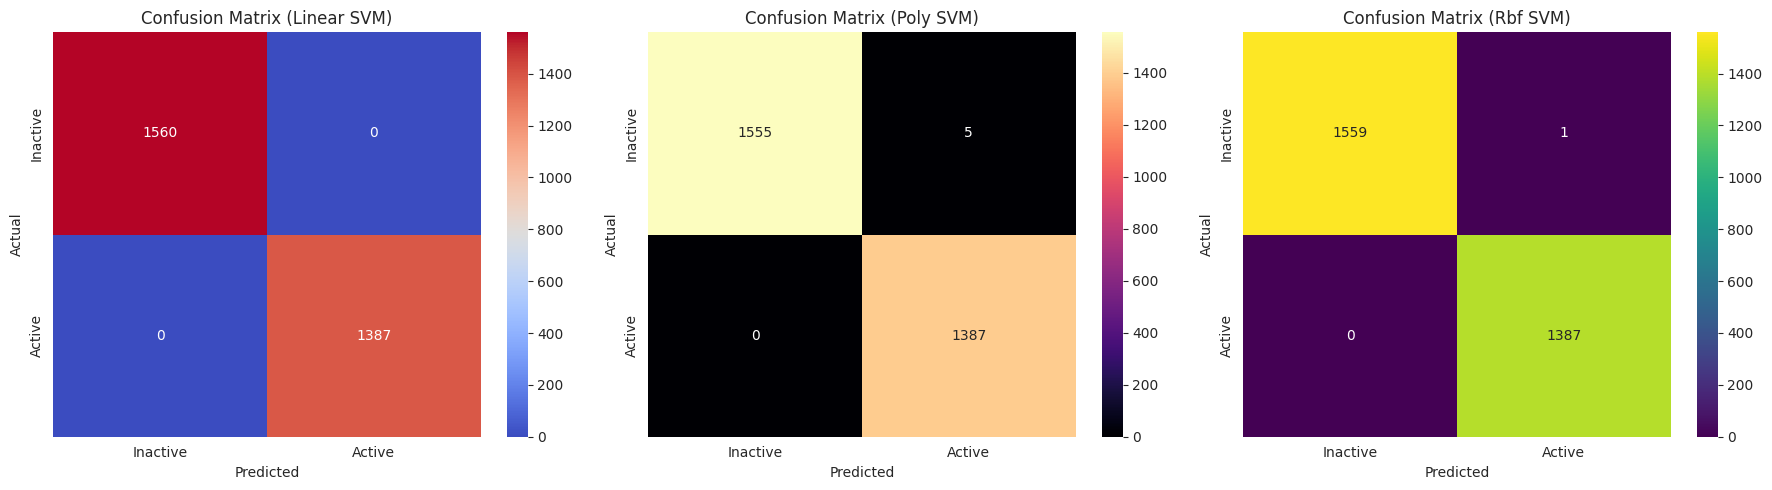

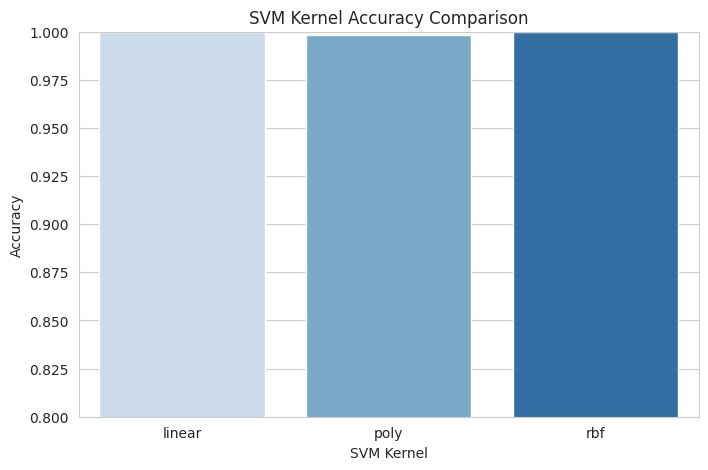

SVM Kernel Accuracy Scores:
Linear SVM: 1.0000
Poly SVM: 0.9983
Rbf SVM: 0.9997


In [1]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Extracting dataset from UCI Repository
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
ZIP_PATH = "UCI_HAR_Dataset.zip"
EXTRACT_PATH = "UCI_HAR_Dataset"

if not os.path.exists(ZIP_PATH):
    print("Downloading")
    response = requests.get(DATASET_URL, stream=True)
    with open(ZIP_PATH, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print("Download complete")

if not os.path.exists(EXTRACT_PATH):
    print("Extracting")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Extraction complete")

# Detect dataset path
for root, dirs, files in os.walk(EXTRACT_PATH):
    if "features.txt" in files:
        DATA_PATH = root
        break


# Adding features and labeling actvities 
features_path = os.path.join(DATA_PATH, "features.txt")
activity_labels_path = os.path.join(DATA_PATH, "activity_labels.txt")

features = pd.read_csv(features_path, sep=r"\s+", header=None, names=["index", "feature"])
features["feature"] = features["feature"].astype(str)  # Ensure string type

# Removing any duplicate feature names to avoid errors 
if features["feature"].duplicated().any():
    features["feature"] += "_" + features["index"].astype(str)
feature_names = features["feature"].tolist()

activity_labels = pd.read_csv(activity_labels_path, sep=r"\s+", header=None, names=["index", "activity"])
activity_map = dict(zip(activity_labels["index"], activity_labels["activity"]))

# Loading, Testing and Training data
def load_data(split="train"):
    X_path = os.path.join(DATA_PATH, split, f"X_{split}.txt")
    y_path = os.path.join(DATA_PATH, split, f"y_{split}.txt")
    subject_path = os.path.join(DATA_PATH, split, f"subject_{split}.txt")
   
    if not all(os.path.exists(p) for p in [X_path, y_path, subject_path]):
        raise FileNotFoundError(f"❌ Missing files in {split} dataset.")
   
    X = pd.read_csv(X_path, sep=r"\s+", header=None, names=feature_names)
    y = pd.read_csv(y_path, sep=r"\s+", header=None, names=["Activity"])
    subjects = pd.read_csv(subject_path, sep=r"\s+", header=None, names=["Subject"])
   
    return X, y, subjects

X_train, y_train, subjects_train = load_data("train")
X_test, y_test, subjects_test = load_data("test")

y_train["Activity"] = y_train["Activity"].map(activity_map)
y_test["Activity"] = y_test["Activity"].map(activity_map)

# Converting multi class to binary (ACTIVE vs INACTIVE) ---
def to_binary_label(activity):
    return 1 if activity in ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"] else 0

y_train["Binary"] = y_train["Activity"].apply(to_binary_label)
y_test["Binary"] = y_test["Activity"].apply(to_binary_label)

y_train_binary = y_train["Binary"]
y_test_binary = y_test["Binary"]

# --- 5. PREPROCESSING: FEATURE SCALING & PCA ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Model with grid search for cross validation
kernels = ['linear', 'poly', 'rbf']
results = {}
conf_matrices = {}

for kernel in kernels:
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50)),
        ('svc', SVC(kernel=kernel, C=1, gamma='scale'))
    ])
    
    model.fit(X_train_scaled, y_train_binary)
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test_binary, y_pred)
    results[kernel] = accuracy
    conf_matrices[kernel] = confusion_matrix(y_test_binary, y_pred)

# Plotting and 
sns.set_style("whitegrid")

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ["coolwarm", "magma", "viridis"]

for ax, (kernel, matrix), cmap in zip(axes, conf_matrices.items(), colors):
    sns.heatmap(matrix, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=['Inactive', 'Active'],
                yticklabels=['Inactive', 'Active'])
    ax.set_title(f'Confusion Matrix ({kernel.capitalize()} SVM)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Accuracy Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), hue=list(results.keys()), palette="Blues", legend=False)
plt.xlabel("SVM Kernel")
plt.ylabel("Accuracy")
plt.title("SVM Kernel Accuracy Comparison")
plt.ylim(0.8, 1.0)
plt.show()

# Print accuracy scores in numerical values
print("SVM Kernel Accuracy Scores:")
for kernel, accuracy in results.items():
    print(f"{kernel.capitalize()} SVM: {accuracy:.4f}")
